In [ ]:
# default_exp fit

From https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html

In [ ]:
#export
import lmfit

# Parameter Fitting (using lmfit)

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/bblais/opt/anaconda3/envs/py3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
from pyndamics3 import Simulation

pyndamics3  version  0.0.3


In [ ]:
import numpy as np

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 10
    # variables        = 3
    chi-square         = 11.5206589
    reduced chi-square = 1.64580842
    Akaike info crit   = 7.41556761
    Bayesian info crit = 8.32332289
[[Variables]]
    x0:  10.0419790 +/- 1.25007200 (12.45%) (init = 9.803012)
    a:   2.51461549 +/- 1.61428086 (64.20%) (init = 1)
    b:   0.61344905 +/- 0.32470181 (52.93%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  =  0.983
    C(x0, b) =  0.422
    C(x0, a) =  0.378


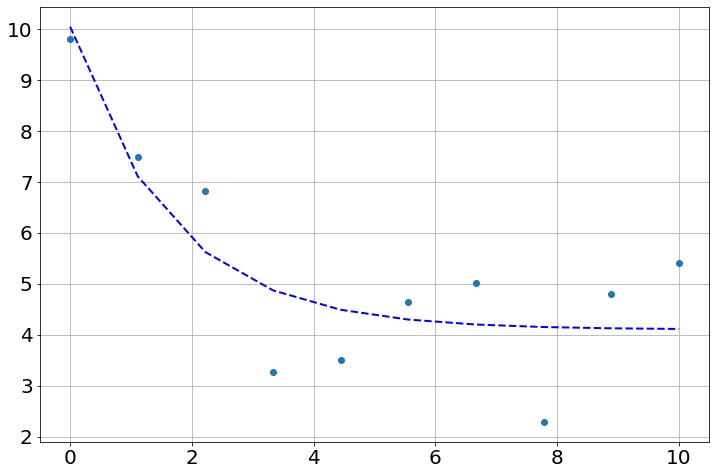

In [ ]:
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

def f(xs, t, ps):
    """Receptor synthesis-internalization model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
    except:
        a, b = ps
    x = xs

    return a - b*x

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

a = 2.0
b = 0.5
true_params = [a, b]
x0 = 10.0


t = np.linspace(0, 10, 10)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value=float(data[0]), min=0, max=100)
params.add('a', value= 1.0, min=0, max=10)
params.add('b', value= 1.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plot(t, data, 'o')
plot(t, final, '--', linewidth=2, c='blue');

# display fitted statistics
report_fit(result)

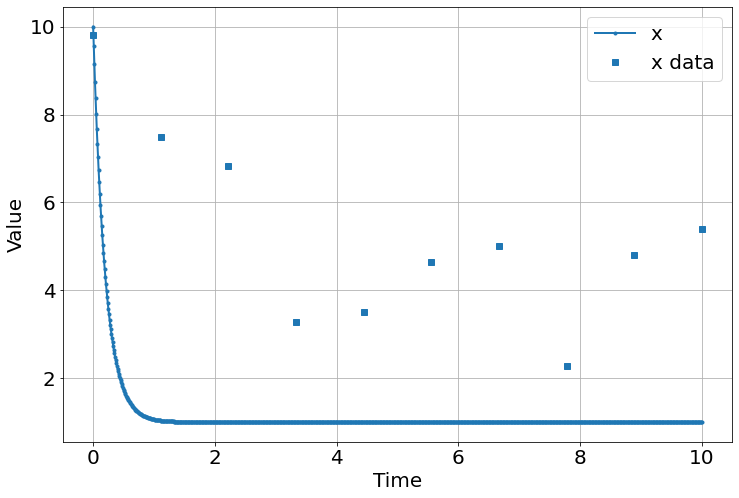

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("x'=a-b*x",10,plot=True)
sim.add_data(t=t,x=data,plot=True)
sim.params(a=5.,b=5)
sim.run(10)


In [ ]:
#export
def Parameter(name,**kwargs):
    from lmfit import Parameters
    params = Parameters()
    params.add(name, **kwargs)
    
    return params


In [ ]:
#export
def residual(ps, sim):
    
    params={}
    for key in ps.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            _c=sim.get_component(name)
            _c.initial_value=ps[key].value
            
        else:
            params[key]=ps[key].value
            
    sim.params(**params)
    
    # run the sim
    sim.run_fast()
    
    # compare with data
    value=0.0
    for _c in sim.components:
        if not _c.data:
            continue
        t=np.array(_c.data['t']).ravel()
        y=np.array(_c.data['value']).ravel()
        y_fit=sim.interpolate(t,_c.name)

        if any(np.isnan(y_fit)):
            return -np.inf

        if any(abs(y_fit)>1e100):
            return -np.inf


        value+=(y-y_fit)

    return value
    

def fit(sim,
       *args):
    
    from lmfit import Parameters,minimize
    
    fitparams=Parameters()
    for arg in args:
        fitparams+=arg
    
    
    result = minimize(residual, fitparams, args=(sim,), method='leastsq')    
    
    params={}
    ps=result.params
    for key in ps.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            _c=sim.get_component(name)
            _c.initial_value=ps[key].value
            
        else:
            params[key]=ps[key].value
            
    sim.params(**params)
    
    
    return result



In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0),
   Parameter('b',value=5,min=0),
   Parameter('initial_x',value=10,min=0))

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 10
    # variables        = 3
    chi-square         = 11.5206568
    reduced chi-square = 1.64580812
    Akaike info crit   = 7.41556578
    Bayesian info crit = 8.32332106
[[Variables]]
    a:          2.51432760 +/- 1.61477605 (64.22%) (init = 1)
    b:          0.61338867 +/- 0.32483049 (52.96%) (init = 5)
    initial_x:  10.0419154 +/- 1.25003686 (12.45%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)         =  0.983
    C(b, initial_x) =  0.422
    C(a, initial_x) =  0.378


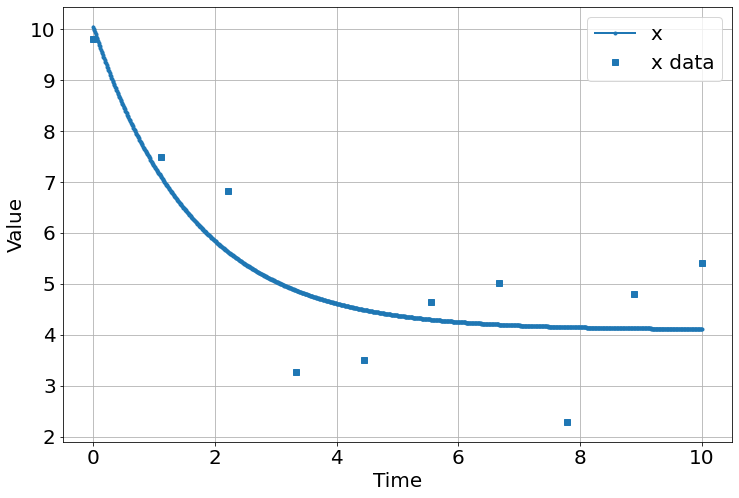

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(10)